# Official contours from case grids
Here we plot temp, u and v. 

streamlines to follow.


In [2]:
import os
import h5py
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

from cmcrameri import cm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os
import h5py

# Define the data folder - must i nclude .h5 cas and dat files.
#data_folder = r"D:\2024 - Thermal Amplifiers - KC\Tr=1.1\Lauren\\"
#data_folder = r"E:\TR_1.0\\"
#data_folder = r"E:\L5\\"
grid_folder = "/Volumes/ThermalAmp/AverageContours/"

#from cmcrameri import cm

In [3]:
data_folder = "/Volumes/ThermalAmp/TR1.8/"
case_files = [data_folder+f for f in os.listdir(data_folder) if f.endswith('.cas.post')]
case_files = [f for f in case_files if "/._" not in f]

fname = os.path.join(data_folder, case_files[0])

# Read the mesh data from the HDF5 file
with h5py.File(fname, 'r') as f:
    vertex_list = np.transpose(f['/meshes/1.post/nodes/coords/1'][:])

# Extract NodeX and NodeY
node_x = vertex_list[0]
node_y = vertex_list[1]

In [4]:
# DOMAIN PARAMETERS - only for plotting purposes.
Ypixels = 1080
XMIN    = -0.25
XMAX    = 0.25
YMIN    = -0.015
YMAX    = 0.085
AspectRatio     = (XMAX-XMIN)/(YMAX-YMIN)
Xpositions      = np.linspace(XMIN,XMAX,int(Ypixels*AspectRatio))
Ypositions      = np.linspace(YMAX,YMIN,Ypixels)
[xgrid,ygrid]   = np.meshgrid(Xpositions,Ypositions)
Clim = [300, 310]


def get_Qavg(SI):

    Tw = 308
    Height = 0.015
    CylinderDiameter = 0.01
    HeightOverDiamter = Height/CylinderDiameter

    Yw = -HeightOverDiamter*CylinderDiameter

    # Define the combined condition for masking
    mask_condition = (ygrid < Yw/1.02) & (xgrid < 0.2) & (xgrid > -0.2)
    y_ = np.unique(ygrid[ygrid <= -0.0147] )
    x_ = np.unique(xgrid[(xgrid < 0.2) & (xgrid > -0.2)])

    # Apply the mask to SI
    SI_masked = np.copy(SI)
    SI_masked[~mask_condition] = np.nan

    Y_ = np.unique(ygrid[ygrid <= Yw/1.02] )
    Y1 = Y_[-3] #3
    Y2 = Y_[-2] #2
    Y3 = Y1**2
    Y4 = Y2**2
    K_ThermalConductivity = 0.02225
    dTdy = []

    left_wall_ind = np.where(xgrid[-1] > -0.2)[0][0]
    right_wall_ind = np.where(xgrid[-1] > 0.2)[0][0]
    SI_slice = SI_masked[:, left_wall_ind:right_wall_ind]

    for c in range(SI_slice.shape[1]):
        T1 = SI_slice[-3, c]
        T2 = SI_slice[-2, c]
        dTdy_value = (T1 * Y4 - T2 * Y3 - Tw * (Y4 - Y3)) / (Y1 * Y4 - Y2 * Y3)
        dTdy.append(dTdy_value)
    Qavg = np.trapz(xgrid[-1][left_wall_ind:right_wall_ind], np.array(dTdy)*K_ThermalConductivity)
    return Qavg


def get_Qavg_line(SI):

    Tw = 308
    Height = 0.015
    CylinderDiameter = 0.01
    HeightOverDiamter = Height/CylinderDiameter

    Yw = -HeightOverDiamter*CylinderDiameter

    # Define the combined condition for masking
    mask_condition = (ygrid < Yw/1.02) & (xgrid < 0.2) & (xgrid > -0.2)
    y_ = np.unique(ygrid[ygrid <= -0.0147] )
    x_ = np.unique(xgrid[(xgrid < 0.2) & (xgrid > -0.2)])

    # Apply the mask to SI
    SI_masked = np.copy(SI)
    SI_masked[~mask_condition] = np.nan

    Y_ = np.unique(ygrid[ygrid <= Yw/1.02] )
    Y1 = Y_[-3]
    Y2 = Y_[-2]
    Y3 = Y1**2
    Y4 = Y2**2
    K_ThermalConductivity = 0.02225
    dTdy = []

    left_wall_ind = np.where(xgrid[-1] > -0.2)[0][0]
    right_wall_ind = np.where(xgrid[-1] > 0.2)[0][0]
    SI_slice = SI_masked[:, left_wall_ind:right_wall_ind]

    for c in range(SI_slice.shape[1]):
        T1 = SI_slice[-3, c]
        T2 = SI_slice[-2, c]
        dTdy_value = (T1 * Y4 - T2 * Y3 - Tw * (Y4 - Y3)) / (Y1 * Y4 - Y2 * Y3)
        dTdy.append(dTdy_value)
    
    return np.array(dTdy)*K_ThermalConductivity


In [5]:
cases = ["1-NoCyl", 0.4, 0.8, 1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.7, 3.5]

ycases = []
Qs = []
All_si = []
All_usi = []
All_vsi = []

for case in cases:
    if os.path.isfile(grid_folder+"/Temp/Tr{}.h5".format(case)):
        print("y")
        with h5py.File(grid_folder+"/Temp/Tr{}.h5".format(case), 'r') as f:
            SI = f['T'][:]
            xpos = f['node_x'][:]
            ypos = f['node_y'][:]
    
            print(case, SI.max(), (SI.max()-298)/(308-298), get_Qavg(SI))
            Qs.append(get_Qavg(SI))
            ycases.append(case)
            All_si.append(SI)

    if os.path.isfile(grid_folder+"/U/Tr{}.h5".format(case)):
        with h5py.File(grid_folder+"/U/Tr{}.h5".format(case), 'r') as f:
            uSI = f['T'][:]
            xpos = f['node_x'][:]
            ypos = f['node_y'][:]
    
            print(SI.max(), (SI.max()-298)/(308-298)), #get_Qavg(uSI))
            #Qs.append(get_Qavg(uSI))

            All_usi.append(uSI)

    if os.path.isfile(grid_folder+"/V/Tr{}.h5".format(case)):
        with h5py.File(grid_folder+"/V/Tr{}.h5".format(case), 'r') as f:
            vSI = f['T'][:]
            xpos = f['node_x'][:]
            ypos = f['node_y'][:]
    
            print(SI.max(), (SI.max()-298)/(308-298)), #get_Qavg(uSI))
            #Qs.append(get_Qavg(uSI))

            All_vsi.append(vSI)
        
            
        #plt.imshow(SI)

y


/var/folders/ry/3sftjhts50x0vr1cmqhbw1z40000gp/T/ipykernel_86822/3280478276.py:49: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Qavg = np.trapz(xgrid[-1][left_wall_ind:right_wall_ind], np.array(dTdy)*K_ThermalConductivity)


1-NoCyl 308.00000000000006 1.0000000000000058 -11.923876940944997
y
0.4 308.00000000000006 1.0000000000000058 -32.61660234649931
308.00000000000006 1.0000000000000058
308.00000000000006 1.0000000000000058
y
0.8 308.00000000000006 1.0000000000000058 -33.04809171745599
308.00000000000006 1.0000000000000058
308.00000000000006 1.0000000000000058
y
1 308.00000000000006 1.0000000000000058 -35.26957093148606
308.00000000000006 1.0000000000000058
308.00000000000006 1.0000000000000058
y
1.1 309.00000000000006 1.1000000000000056 -35.462650969141805
309.00000000000006 1.1000000000000056
309.00000000000006 1.1000000000000056
y
1.2 310.00000000000006 1.2000000000000057 -35.43552997308453
310.00000000000006 1.2000000000000057
310.00000000000006 1.2000000000000057
y
1.3 311.00000000000006 1.3000000000000056 -35.46190330072051
311.00000000000006 1.3000000000000056
311.00000000000006 1.3000000000000056
y
1.4 312.00000000000006 1.4000000000000057 -35.94466309743501
312.00000000000006 1.4000000000000057


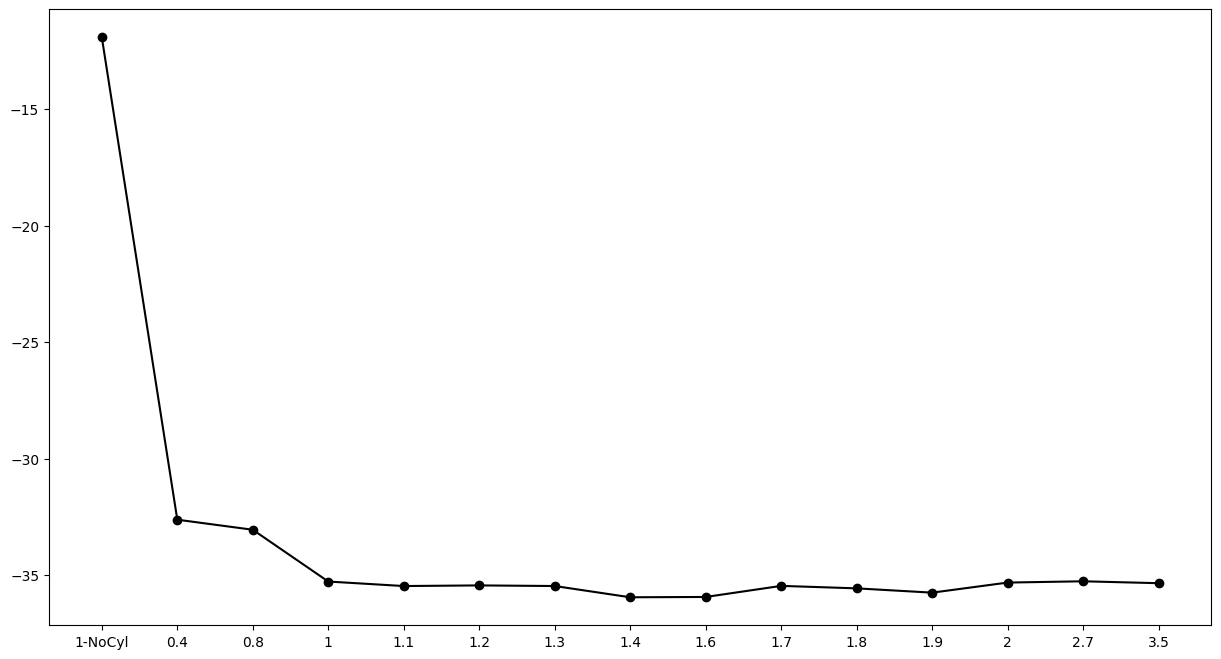

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
plt.scatter([str(c) for c in ycases], Qs, color='k')
plt.plot([str(c) for c in ycases], Qs, color='k')

(0.4, 3.5)

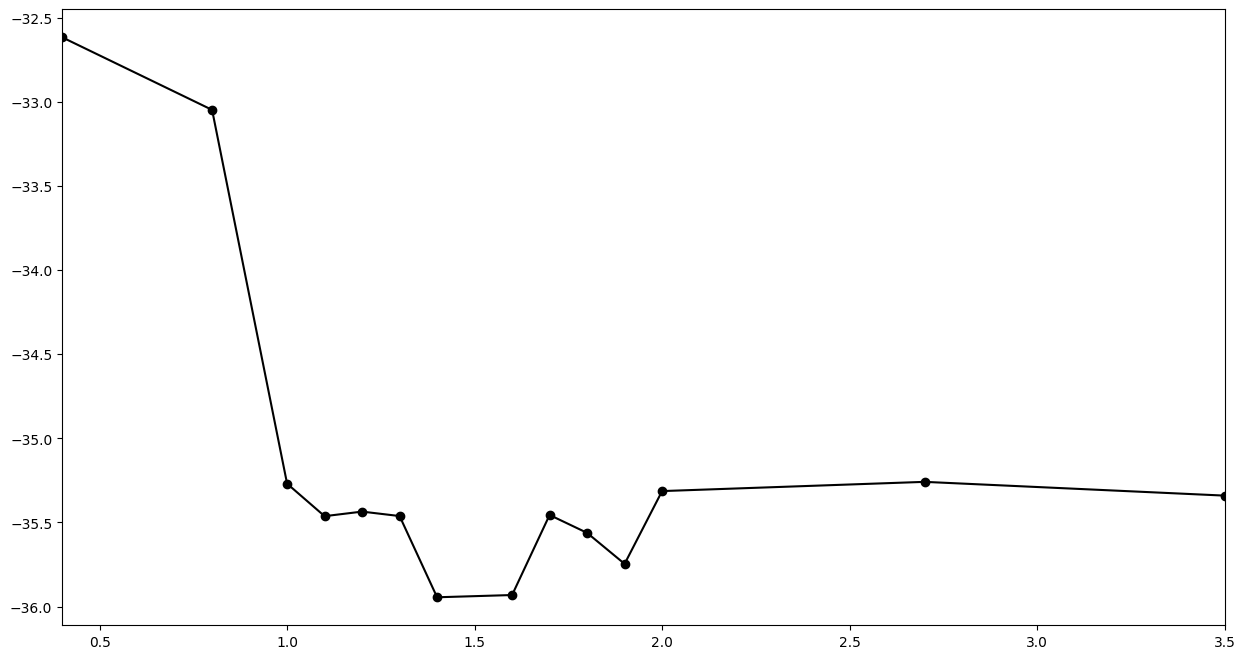

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax.scatter(ycases[1:], Qs[1:], color='k')
ax.plot(ycases[1:], Qs[1:], color='k')
ax.set_xlim([0.4, 3.5])

In [46]:
ycases[1:]

[0.4, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 1.9, 2, 2.7, 3.5]

In [8]:
ta=298
tw=308
D = 0.01

In [20]:
print(len(ycases))
ycases

15


['1-NoCyl', 0.4, 0.8, 1, 1.1, 1.2, 1.3, 1.4, 1.6, 1.7, 1.8, 1.9, 2, 2.7, 3.5]

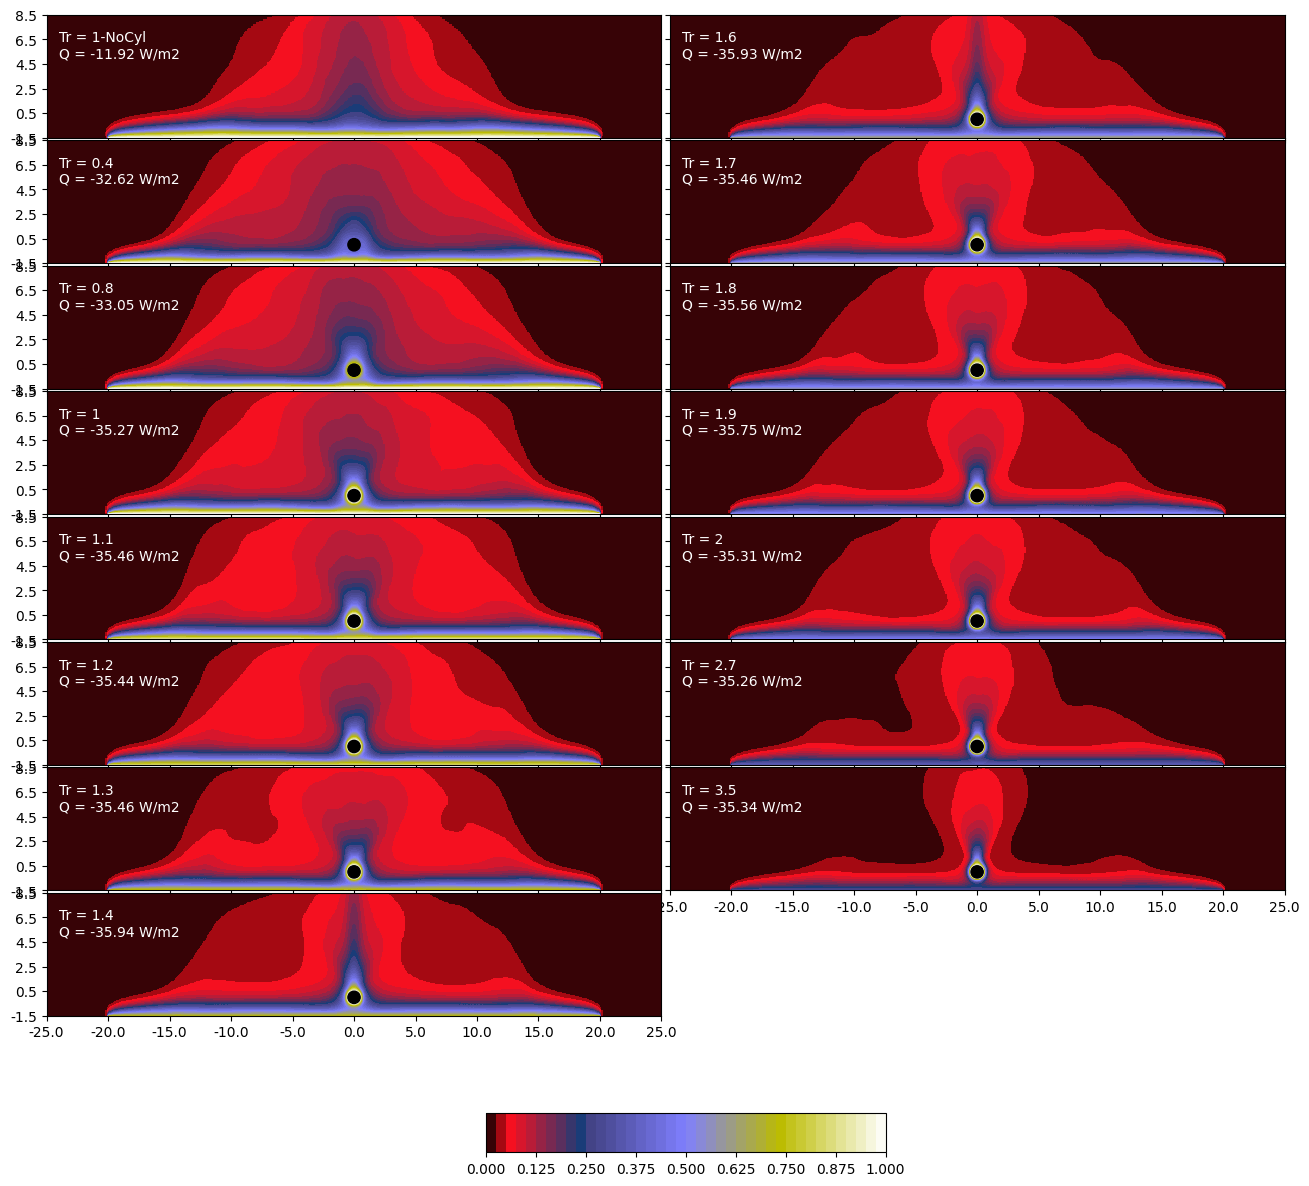

In [14]:
fig, axes = plt.subplots(8, 2, figsize=(16, 13))
#axes = axes.ravel()  # Flatten the 2D array to 1D for easy indexing
fig.subplots_adjust(hspace=0.02, wspace=0.01)  # Adjust space between plots

nrows, ncols = 8, 2
reordered_axes = [axes[r, c] for c in range(ncols) for r in range(nrows)]


yposs = np.arange(0.005, -0.1, -0.05)
for i, ax in enumerate(reordered_axes):

    if i == 15:
        continue
    #im = ax.imshow(All_si[i], cmap='turbo', vmin=298, vmax=325, extent=[XMIN, XMAX, YMIN, YMAX])
    im = ax.contourf(xgrid, ygrid, (All_si[i]-ta)/(All_si[i].max()-ta), cmap='gist_stern', levels=40, extent=[XMIN, XMAX, YMIN, YMAX], origin='lower')
    
    
    ax.text(-0.24,0.05, "Tr = {} \nQ = {} W/m2".format(ycases[i], round(Qs[i], 2)), color='w')
    ax.set_aspect('equal')
    circle = patches.Circle((0,0), radius=0.005, edgecolor='k', facecolor='k')
    if i != 0:
        ax.add_patch(circle)

    ax.set_ylim([-0.015, 0.085])
    ax.set_xlim([-0.25, 0.25])
    x_ticks = np.arange(-0.25, 0.26, 0.05)
    ax.set_xticks(x_ticks)
    y_ticks = np.arange(-0.015, 0.086, 0.02)
    ax.set_yticks(y_ticks)
    ax.set_aspect('equal')

    
    if i not in [7, 14]:
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels(np.arange(XMIN/D, XMAX/D+0.1, 5))
    if i > 7:
        ax.set_yticklabels([])
    else:
        ax.set_yticklabels(np.linspace(YMIN/D, YMAX/D, 6))

fig.delaxes(axes[7,1])

cb_ax = fig.add_axes([0.4, 0.005, 0.25, 0.03])
plt.colorbar(im, cax=cb_ax, orientation='horizontal', shrink=0.8, extend='max')

#plt.savefig("./plot.pdf", bbox_inches='tight', dpi=500)

In [59]:
All_si[i]

np.float64(333.00000000000006)

In [57]:
(All_si[i]-ta)/(tw-ta)

array([[9.45760803e-11, 9.45760803e-11, 9.45760803e-11, ...,
        9.04776698e-11, 9.04776698e-11, 9.04776698e-11],
       [9.45760803e-11, 9.45760803e-11, 9.45760803e-11, ...,
        9.04776698e-11, 9.04776698e-11, 9.04776698e-11],
       [9.45760803e-11, 9.45760803e-11, 9.45760803e-11, ...,
        9.04776698e-11, 9.04776698e-11, 9.04776698e-11],
       ...,
       [1.07198741e-07, 1.07198741e-07, 1.07198741e-07, ...,
        1.10102098e-07, 1.10102098e-07, 1.10102098e-07],
       [3.56207181e-08, 3.56207181e-08, 3.56207181e-08, ...,
        3.65870619e-08, 3.65870619e-08, 3.65870619e-08],
       [8.88972522e-09, 8.88972522e-09, 8.88972522e-09, ...,
        9.13104259e-09, 9.13104259e-09, 9.13104259e-09]])

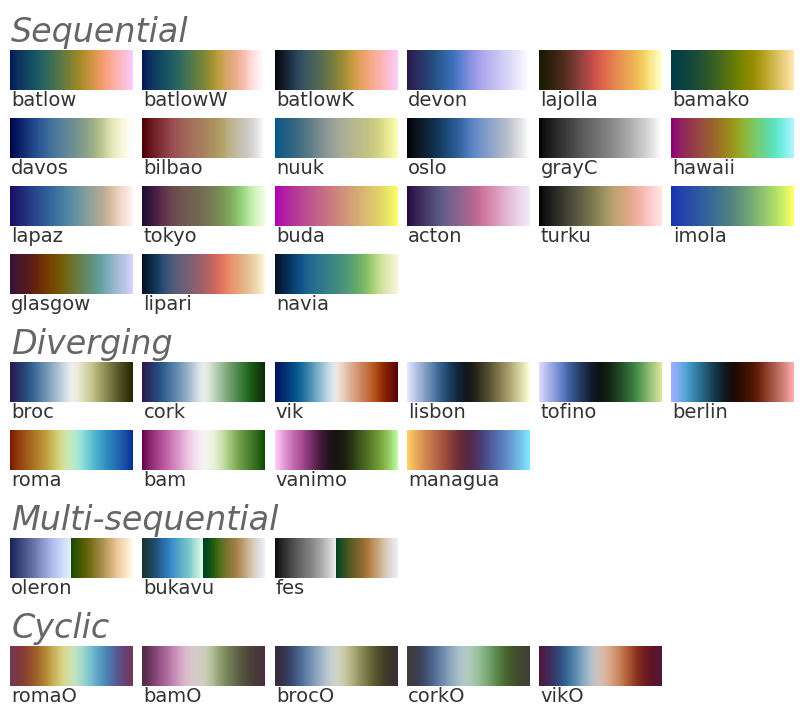

In [110]:
cm.show_cmaps()

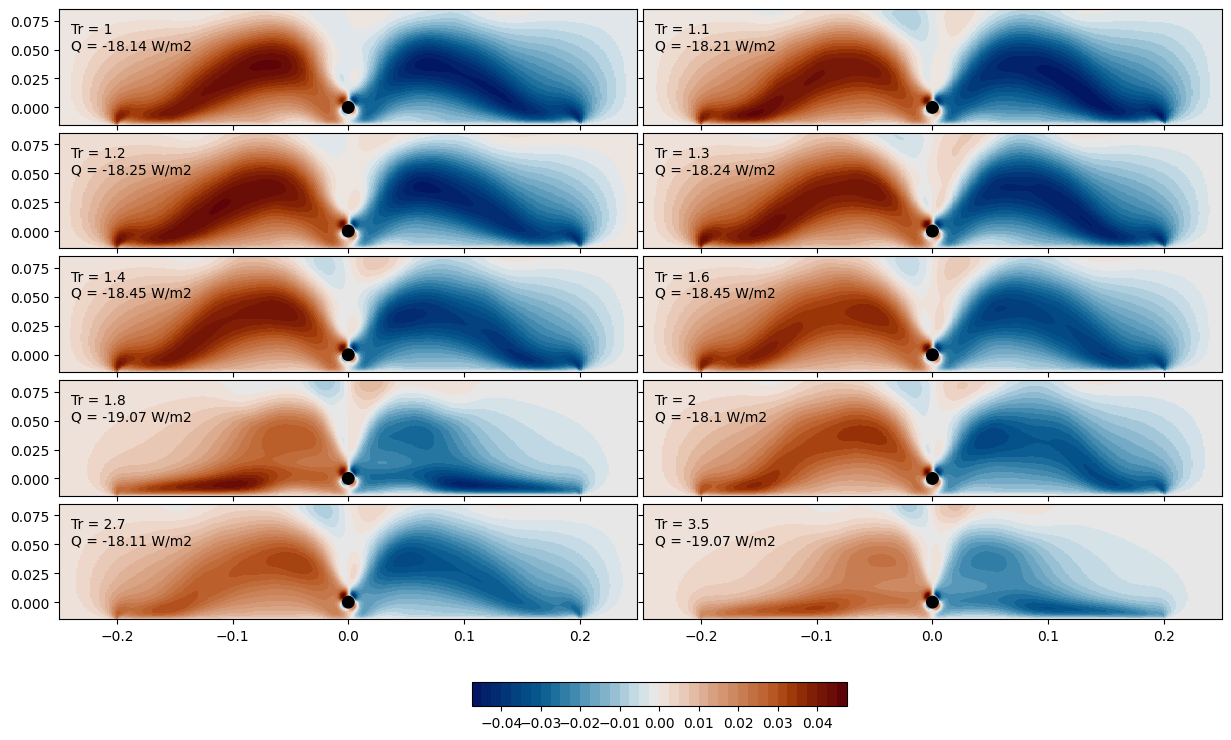

In [195]:
from matplotlib.colors import LinearSegmentedColormap

fig, axes = plt.subplots(5, 2, figsize=(15, 8))
axes = axes.ravel()  # Flatten the 2D array to 1D for easy indexing
fig.subplots_adjust(hspace=0.02, wspace=0.01)  # Adjust space between plots

for i, ax in enumerate(axes):

    if i == 0:
        continue
    #im = ax.imshow(All_si[i], cmap='turbo', vmin=298, vmax=325, extent=[XMIN, XMAX, YMIN, YMAX])
    im = ax.contourf(xgrid, ygrid, All_usi[i], cmap=cm.vik, levels=40, extent=[XMIN, XMAX, YMIN, YMAX])
    #ax.set_title("Tr = {}, Q = {} W/m2".format(cases[i], round(Qs[i], 2)))
    ax.text(-0.24,0.05, "Tr = {} \nQ = {} W/m2".format(cases[i], round(Qs[i], 2)), color='k')
    ax.set_aspect('equal')
    circle = patches.Circle((0,0), radius=0.005, edgecolor='k', facecolor='k')
    ax.add_patch(circle)
    
    if i < 6:
        ax.set_xticklabels([])
    if i % 2 != 0:
        ax.set_yticklabels([])

cb_ax = fig.add_axes([0.4, 0.005, 0.25, 0.03])
plt.colorbar(im, cax=cb_ax, orientation='horizontal', shrink=0.8, extend='max')

#plt.savefig("./plot.pdf", bbox_inches='tight', dpi=500)

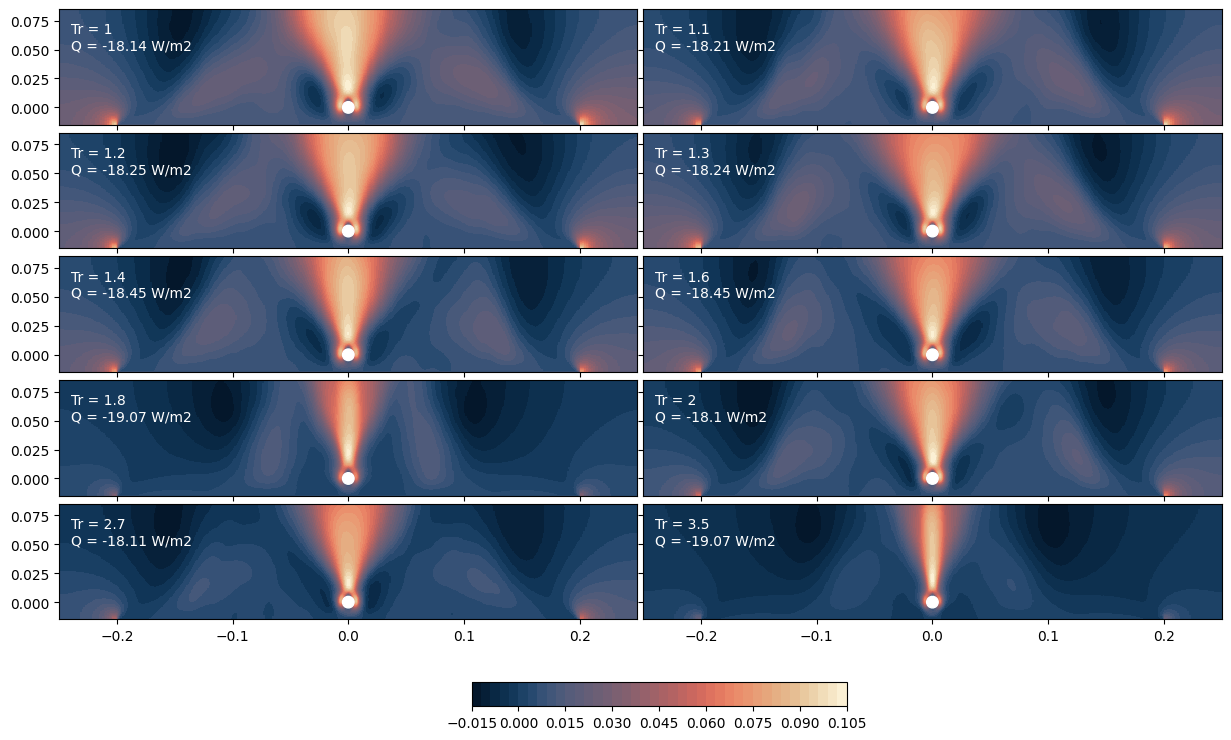

In [204]:
fig, axes = plt.subplots(5, 2, figsize=(15, 8))
axes = axes.ravel()  # Flatten the 2D array to 1D for easy indexing
fig.subplots_adjust(hspace=0.02, wspace=0.01)  # Adjust space between plots

for i, ax in enumerate(axes):
    
    if i == 0:
        continue
    #im = ax.imshow(All_si[i], cmap='turbo', vmin=298, vmax=325, extent=[XMIN, XMAX, YMIN, YMAX])
    im = ax.contourf(xgrid, ygrid, All_vsi[i], cmap=cm.lipari, levels=40, extent=[XMIN, XMAX, YMIN, YMAX])
    #ax.set_title("Tr = {}, Q = {} W/m2".format(cases[i], round(Qs[i], 2)))
    ax.text(-0.24,0.05, "Tr = {} \nQ = {} W/m2".format(cases[i], round(Qs[i], 2)), color='w')
    ax.set_aspect('equal')
    circle = patches.Circle((0,0), radius=0.005, edgecolor='w', facecolor='w')
    ax.add_patch(circle)
    
    if i < 6:
        ax.set_xticklabels([])
    if i % 2 != 0:
        ax.set_yticklabels([])

cb_ax = fig.add_axes([0.4, 0.005, 0.25, 0.03])
plt.colorbar(im, cax=cb_ax, orientation='horizontal', shrink=0.8, extend='max')

#plt.savefig("./plot.pdf", bbox_inches='tight', dpi=500)

/var/folders/ry/3sftjhts50x0vr1cmqhbw1z40000gp/T/ipykernel_37979/1040411835.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.arange(XMIN/D, XMAX/D+0.1, 5))
/var/folders/ry/3sftjhts50x0vr1cmqhbw1z40000gp/T/ipykernel_37979/1040411835.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.linspace(YMIN/D, YMAX/D, 6))
/var/folders/ry/3sftjhts50x0vr1cmqhbw1z40000gp/T/ipykernel_37979/1040411835.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.arange(XMIN/D, XMAX/D+0.1, 5))
/var/folders/ry/3sftjhts50x0vr1cmqhbw1z40000gp/T/ipykernel_37979/1040411835.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLo

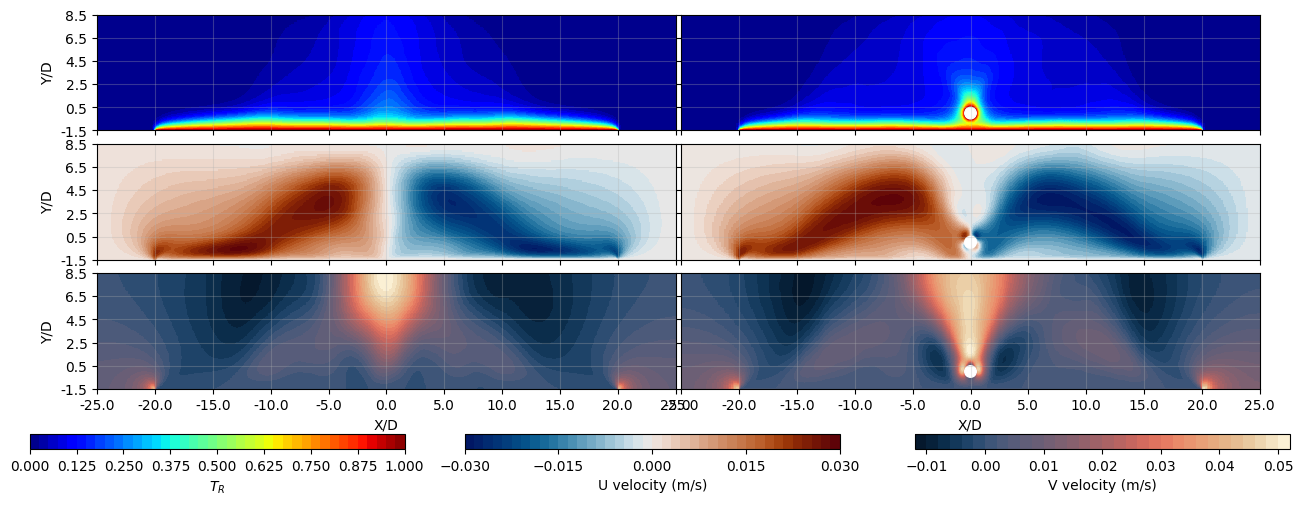

In [108]:
fig, axes = plt.subplots(3, 2, figsize=(15, 5))
axes = axes.ravel()  # Flatten the 2D array to 1D for easy indexing
fig.subplots_adjust(hspace=0.02, wspace=0.01)  # Adjust space between plots

#im = ax.imshow(All_si[i], cmap='turbo', vmin=298, vmax=325, extent=[XMIN, XMAX, YMIN, YMAX])
im = axes[0].contourf(xgrid, ygrid, (All_si[0] - 298)/(All_si[0].max()-298), cmap='jet', levels=40, extent=[XMIN, XMAX, YMIN, YMAX])
#ax.set_title("Tr = {}, Q = {} W/m2".format(cases[i], round(Qs[i], 2)))
#axes[0].text(-0.24,0.05, "Tr = {} \nQ = {} W/m2".format(cases[0], round(Qs[0], 2)), color='w')
axes[0].set_aspect('equal')

im2 = axes[1].contourf(xgrid, ygrid, (All_si[1] - 298)/(All_si[1].max()-298), cmap='jet', levels=40, extent=[XMIN, XMAX, YMIN, YMAX])
#ax.set_title("Tr = {}, Q = {} W/m2".format(cases[i], round(Qs[i], 2)))
#axes[1].text(-0.24,0.05, "Tr = {} \nQ = {} W/m2".format(cases[1], round(Qs[1], 2)), color='w')
axes[1].set_aspect('equal')
circle = patches.Circle((0,0), radius=0.005, edgecolor='w', facecolor='w')
axes[1].add_patch(circle)

im3 = axes[2].contourf(xgrid, ygrid, All_usi[0], cmap=cm.vik, levels=40, extent=[XMIN, XMAX, YMIN, YMAX])
#ax.set_title("Tr = {}, Q = {} W/m2".format(cases[i], round(Qs[i], 2)))
#axes[2].text(-0.24,0.05, "Tr = {} \nQ = {} W/m2".format(cases[0], round(Qs[0], 2)), color='w')
axes[2].set_aspect('equal')

im4 = axes[3].contourf(xgrid, ygrid, All_usi[1], cmap=cm.vik, levels=40, extent=[XMIN, XMAX, YMIN, YMAX])
#ax.set_title("Tr = {}, Q = {} W/m2".format(cases[i], round(Qs[i], 2)))
#axes[3].text(-0.24,0.05, "Tr = {} \nQ = {} W/m2".format(cases[1], round(Qs[1], 2)), color='w')
axes[3].set_aspect('equal')
circle = patches.Circle((0,0), radius=0.005, edgecolor='w', facecolor='w')
axes[3].add_patch(circle)

im5 = axes[4].contourf(xgrid, ygrid, All_vsi[0], cmap=cm.lipari, levels=40, extent=[XMIN, XMAX, YMIN, YMAX])
#ax.set_title("Tr = {}, Q = {} W/m2".format(cases[i], round(Qs[i], 2)))
#axes[4].text(-0.24,0.05, "Tr = {} \nQ = {} W/m2".format(cases[0], round(Qs[0], 2)), color='w')
axes[4].set_aspect('equal')

im6 = axes[5].contourf(xgrid, ygrid, All_vsi[1], cmap=cm.lipari, levels=40, extent=[XMIN, XMAX, YMIN, YMAX])
#ax.set_title("Tr = {}, Q = {} W/m2".format(cases[i], round(Qs[i], 2)))
#axes[5].text(-0.24,0.05, "Tr = {} \nQ = {} W/m2".format(cases[1], round(Qs[1], 2)), color='w')
axes[5].set_aspect('equal')
circle = patches.Circle((0,0), radius=0.005, edgecolor='w', facecolor='w')
axes[5].add_patch(circle)

for i, ax in enumerate(axes):
    ax.set_ylim([-0.015, 0.085])
    ax.set_xlim([-0.25, 0.25])
    ax.set_aspect('equal')
    ax.grid(alpha=0.3)
    # Manually set x ticks and labels
    x_ticks = np.arange(-0.25, 0.26, 0.05)
    x_labels = ['Zero', 'One', 'Two', 'Three']

    ax.set_xticklabels(np.arange(XMIN/D, XMAX/D+0.1, 5))
    ax.set_yticklabels(np.linspace(YMIN/D, YMAX/D, 6))

    ax.set_xticks(x_ticks)
    # Manually set y ticks and labels
    y_ticks = np.arange(-0.015, 0.086, 0.02)
    y_labels = ['Zero', 'Three', 'Six', 'Nine']
    ax.set_yticks(y_ticks)

    if i < 4:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("X/D")
    if i % 2 != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel("Y/D")

cb_ax = fig.add_axes([0.08, 0.0, 0.25, 0.03])
cb = plt.colorbar(im, cax=cb_ax, orientation='horizontal', shrink=0.2, pad=0.7, label="$T_R$", extend='max')

cb_ax = fig.add_axes([0.37, 0.0, 0.25, 0.03])
cb2 = plt.colorbar(im3, cax=cb_ax, orientation='horizontal', shrink=0.2, pad=0.7, label="U velocity (m/s)")
tick_locations = np.arange(-0.03,0.0301,0.015)
cb2.set_ticks(tick_locations)

cb_ax = fig.add_axes([0.67, 0.0, 0.25, 0.03])
cb3 = plt.colorbar(im5, cax=cb_ax, orientation='horizontal', shrink=0.2, pad=0.7, label="V velocity (m/s)", extend='max')
tick_locations = np.arange(-0.01,0.051,0.01)
cb3.set_ticks(tick_locations)

plt.savefig("./compare-cyl-no-cyl.png", bbox_inches='tight', dpi=500)

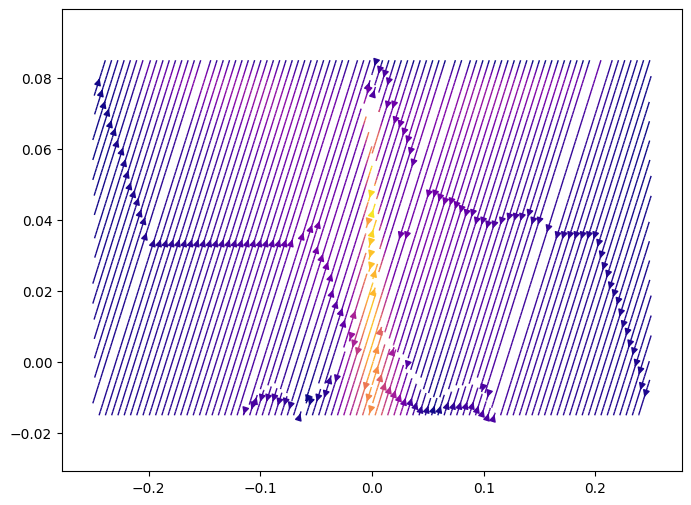

In [226]:
plt.figure(figsize=(8, 6))
plt.streamplot(np.sort(xgrid), np.sort(ygrid), All_usi[i], All_usi[i], color=np.sqrt(All_usi[i]**2 + All_vsi[i]**2), density=3, cmap='plasma', linewidth=1)


In [22]:
len(All_si)

15

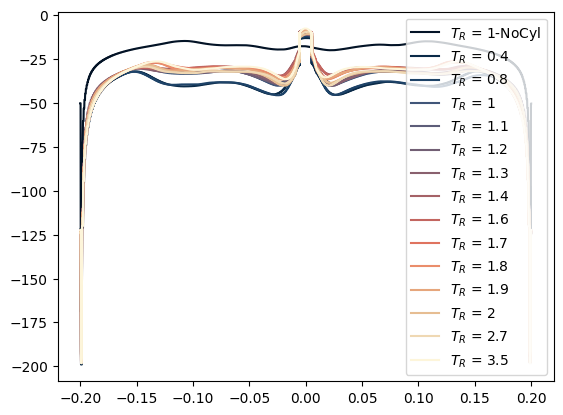

In [24]:
left_wall_ind = np.where(xgrid[-1] > -0.2)[0][0]
right_wall_ind = np.where(xgrid[-1] > 0.2)[0][0]

num_colors = 15
colormap = cm.lipari
colors = [colormap(i) for i in np.linspace(0, 1, num_colors)]

for i, SI in enumerate(All_si):
    Q_line = get_Qavg_line(SI)
    plt.plot(xgrid[-1][left_wall_ind:right_wall_ind], Q_line, color=colors[i], label="$T_R$ = {}".format(ycases[i]))
plt.legend()

Text(0.5, 0, 'Wall length')

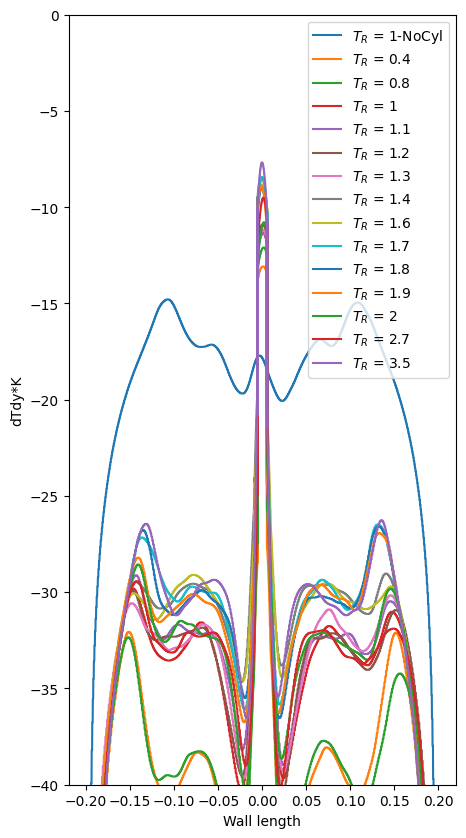

In [26]:
num_colors = 15
colormap = cm.lajolla
colors = [colormap(i) for i in np.linspace(0, 1, num_colors)]
maxQ = []
fig, ax = plt.subplots(1, 1, figsize=(5, 10))
for i, SI in enumerate(All_si):
    Q_line = get_Qavg_line(SI)
    maxQ.append(np.max(Q_line))
    ax.plot(xgrid[-1][left_wall_ind:right_wall_ind], Q_line,  label="$T_R$ = {}".format(ycases[i]))
ax.legend()
ax.set_ylim([-40,0])
#ax.set_aspect('equal')
ax.set_ylabel("dTdy*K")
ax.set_xlabel("Wall length")

Text(0, 0.5, 'Q')

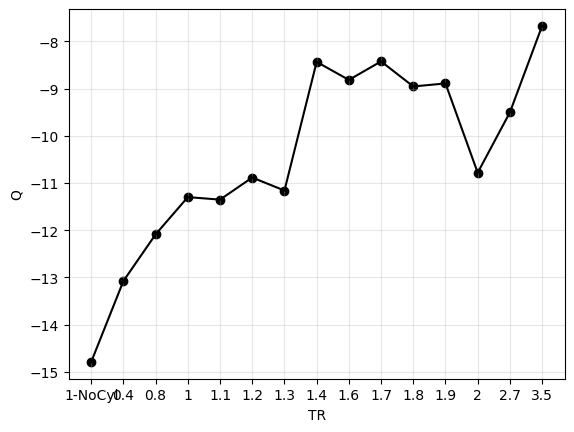

In [28]:
plt.scatter([str(c) for c in ycases], maxQ, color='k')
plt.plot([str(c) for c in ycases], maxQ, color='k')
plt.grid(alpha=0.3)
plt.xlabel("TR")
plt.ylabel("Q")

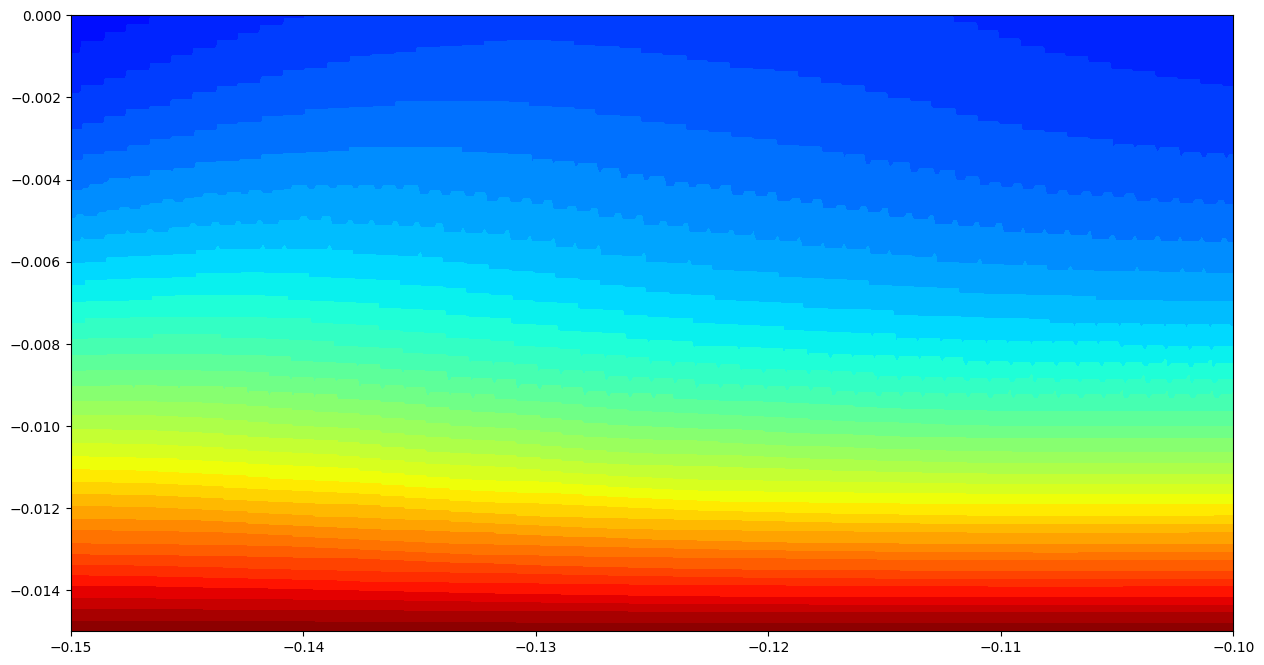

In [23]:

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
im = ax.contourf(xgrid, ygrid, (All_si[1]-ta)/(All_si[1].max()-ta), cmap='jet', levels=40, extent=[XMIN, XMAX, YMIN, YMAX], origin='lower')
ax.set_ylim([-0.015, -0.0])
ax.set_xlim([-0.15, -0.1])
ax.scatter(xgrid, ygrid, alpha=0.3, s=0.07, marker='s', color='k')